# Spatial Analysis of Temperature Variations

This notebook focuses on the spatial analysis of temperature variations across different regions of California. The objective is to map average temperatures at different geographic levels, identify regions with significant temperature variations and visualize possible hotspots.

### Learnings:
- Identify regions in California with significant temperature variations.
- Detect potential temperature hotspots.
- Understand the spatial distribution of temperature.

## Set Up

In [2]:
from pykrige.ok import OrdinaryKriging
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import sys

# Update paths to get source code from notebook_utils
curr_dir = os.path.dirname(os.path.abspath('notebooks'))
proj_dir = os.path.dirname(curr_dir)
src_path = os.path.join(proj_dir, 'src')
sys.path.append(src_path)

from notebook_utils.preprocessing import *
from notebook_utils.spatial_analysis import *

# Create combined dataframe from ghcn_cleaned files
CA_stations = combine_files_to_dfs('../data/processed/ghcn_cleaned')    # change to add bottom line

Processed file: CA_2003_clean.csv
Processed file: CA_2004_clean.csv
Processed file: CA_2005_clean.csv
Processed file: CA_2006_clean.csv
Processed file: CA_2007_clean.csv
Processed file: CA_2008_clean.csv
Processed file: CA_2009_clean.csv
Processed file: CA_2010_clean.csv
Processed file: CA_2011_clean.csv
Processed file: CA_2012_clean.csv
Processed file: CA_2013_clean.csv
Processed file: CA_2014_clean.csv
Processed file: CA_2015_clean.csv
Processed file: CA_2016_clean.csv
Processed file: CA_2017_clean.csv
Processed file: CA_2018_clean.csv
Processed file: CA_2019_clean.csv
Processed file: CA_2020_clean.csv
Processed file: CA_2021_clean.csv
Processed file: CA_2022_clean.csv
Processed file: CA_2023_clean.csv


# Load Spatial Data

In [ ]:
# Load California places, county, and state boundary shapefiles
county_gdf = gpd.read_file('../data/raw/shapefiles/CA_County_Boundaries/CA_Counties.shp')
places_gdf = gpd.read_file('../data/raw/shapefiles/CA_Places_Boundaries/CA_Places.shp')
state_gdf = gpd.read_file('../data/raw/shapefiles/CA_State_Boundaries/CA_State.shp')

### Reproject GeoDataFrames to match temperature data's Coordinate Reference System

In [ ]:
county_gdf = county_gdf.to_crs(epsg=4326)
places_gdf = places_gdf.to_crs(epsg=4326)
state_gdf = state_gdf.to_crs(epsg=4326)

### Convert dataframe to geodataframe

In [3]:
geometry = [Point(xy) for xy in zip(CA_stations['Longitude'], CA_stations['Latitude'])]
CA_stations_gdf = gpd.GeoDataFrame(CA_stations,geometry=geometry,crs='EPSG:4326')

### Get station averages

In [4]:
station_yearly_avg_temp = CA_stations_gdf.groupby(['Station_ID', 'Year'])['Temperature'].mean().round(1).reset_index()

CA_stations_avg_gdf = CA_stations_gdf.drop_duplicates(subset=['Station_ID','Year'])
CA_stations_avg_gdf = CA_stations_avg_gdf.merge(station_yearly_avg_temp, on=['Station_ID', 'Year'], suffixes=('', '_avg'))

# Merge Data

## Combine station data with spatial data

### County Boundaries

In [ ]:
# Spatial join between temperature data and county boundaries
county_temp_gdf = gpd.sjoin(CA_stations_gdf, county_gdf, how='inner', predicate='intersects')
county_avg = county_temp_gdf.groupby('NAME')['Temperature'].mean().reset_index()
county_gdf = county_gdf.merge(county_avg,  on='NAME', how='left')
county_gdf.rename(columns={'Temperature_y': 'Temperature'}, inplace=True)

### City/Place Boundaries

In [ ]:
# Spatial join between temperature data and places boundaries
places_temp_gdf = gpd.sjoin(CA_stations_gdf, places_gdf, how="inner", predicate='intersects')
place_avg = places_temp_gdf.groupby('NAME')['Temperature'].mean().reset_index()
gdf_places = places_gdf.merge(place_avg, on='NAME')

# Visualization

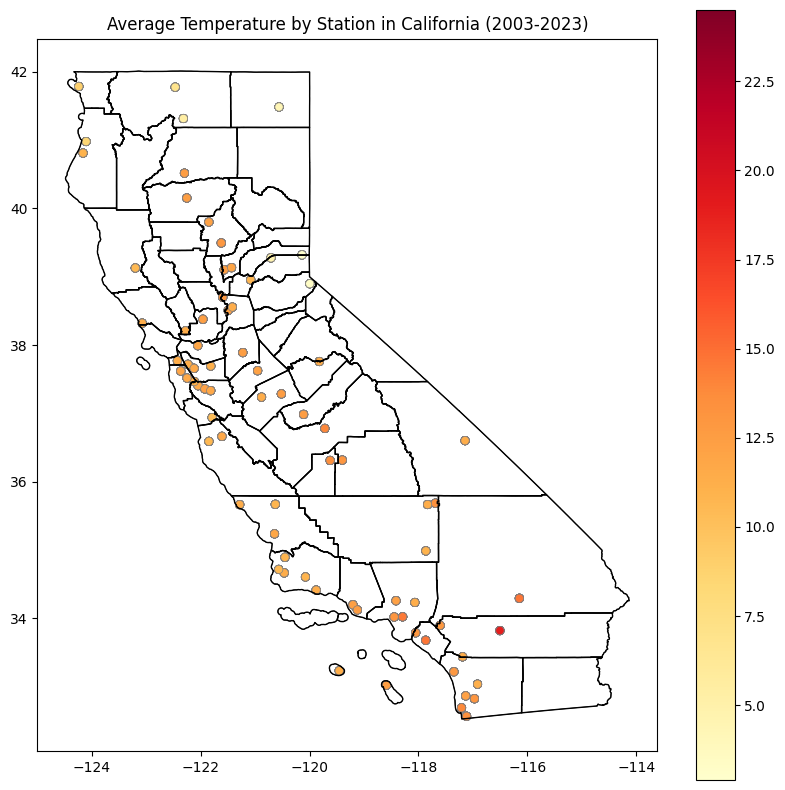

In [ ]:
county_gdf['Temperature'].fillna(np.nan)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
county_gdf.boundary.plot(ax=ax, linewidth=1, color='black', label='County Boundaries')
county_gdf.boundary.plot(ax=ax,linewidth=0.5,color='black')
CA_stations_avg_gdf.plot(column='Temperature_avg', cmap='YlOrRd', linewidth=0.5, ax=ax, edgecolor='0.5', legend=True)
ax.set_title('Average Temperature by Station in California (2003-2023)')
plt.show()

In [ ]:
CA_stations.head()

,Station_ID,Station_name,Latitude,Longitude,datetime,Year,Month,Day,Hour,Temperature,Season,County,City
0,USW00023224,AUBURN MUNI AP,38.9547,-121.0819,2003-01-01 00:00:00,2003,1,1,0,5.2,Winter,Placer County,Auburn
1,USW00023224,AUBURN MUNI AP,38.9547,-121.0819,2003-01-01 01:00:00,2003,1,1,1,5.0,Winter,Placer County,Auburn
2,USW00023224,AUBURN MUNI AP,38.9547,-121.0819,2003-01-01 02:00:00,2003,1,1,2,4.8,Winter,Placer County,Auburn
3,USW00023224,AUBURN MUNI AP,38.9547,-121.0819,2003-01-01 03:00:00,2003,1,1,3,4.6,Winter,Placer County,Auburn
4,USW00023224,AUBURN MUNI AP,38.9547,-121.0819,2003-01-01 04:00:00,2003,1,1,4,4.3,Winter,Placer County,Auburn


In [5]:
create_interactive_map(CA_stations_avg_gdf)